In [1]:
import pandas as pd
import numpy as np
from tools.hrf import create_regressor, create_hrf
from tools.glm import glm, n_back_series, add_regressors, array2dummies
from config import root
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.minor.size'] = 1
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.minor.width'] = 2

matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.minor.size'] = 1
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.minor.width'] = 2

from scipy import interp, signal, stats

import os

## Load

In [2]:
# sessions per subject.
sessions = {1: [0,1,2,3],
            2: [0,1],
            3: [0,1,2,3],
            4: [0,1,2],
            5: [0,1,2,3],
            6: [0,1]}

In [3]:
TR = 2.1
nslices = 205
length = nslices * TR
nback = 6

In [4]:
raw_files = os.path.join(root, "data", "output", "highpass", "ses_%03dsub_%03d")

In [5]:
stimuli = pd.read_csv("../data/loc_and_clr.csv")

## Example glm

In [6]:
# Select a scan
sub, ses, scn = (6, 1, 4)
run = 12
reg_num = 1
nback = 2

# Stimulus onsets and amplitude
group = stimuli.set_index(["sub", "real_ses", "scn"]).loc[(sub, ses, scn), :]
onsets = group.onset
length = nslices * TR

X = array2dummies(group.tgt_loc.values)
X = add_regressors(X, n_back_series(group.tgt_loc.values, nback))
X = add_regressors(X, n_back_series(group.tgt_clr.values, nback))
    
# Create regressors, convolved with hrf
regs = []
tu = .1
hrf = create_hrf(time_unit=tu, undershoot_delay=12, response_delay=5, resp_undershoot_ratio=6)
for i, x in enumerate(X):
    t, reg = create_regressor(length, onsets, x, hrf=hrf, time_unit=tu)

    diff = np.append(np.diff(reg), 0)
    
    reg -= reg.mean()
    diff -= diff.mean()
    
    regs.append(reg)
    regs.append(diff)
    
regs = np.array(regs)

# Load regressors, convolved with HRF, by FSL
# to compare
mat_path = os.path.join(
    root, 
    "data", 
    "working_dir/glm/pop_decay_firstlevel/_sub_id_sub_%03d/pop_decay_featmodel_ses%d/mapflow/_pop_decay_featmodel_ses%d%d" % (sub, ses, ses, run), 
    "run12.mat")
mat = pd.read_csv(mat_path, skiprows=5, sep="\s+", header=None)

### Compare regs to FSL's regs

(0.9455943324285084, 6.003301583845889e-101)
(0.8461103118538026, 2.2197855176421598e-57)
(0.9705635643954998, 1.7917743387785667e-127)
(0.8379977524606692, 2.635853161129392e-55)
(0.9603524715408193, 1.4318648338195685e-114)
(0.8425981924063257, 1.8149791095330894e-56)
(0.9701461058453394, 7.326207752038681e-127)
(0.837030145875801, 4.578326898839796e-55)
(0.9785861780965115, 2.5261195645978495e-141)
(0.8491826205751899, 3.381478927750205e-58)
(0.7215250218932283, 3.009381206957029e-34)
(0.6335278168129016, 2.1149147557332644e-24)
(0.9600942302323913, 2.7314735945405863e-114)
(0.8215489522723446, 1.9767154370508635e-51)
(0.8408528932555145, 5.059104500463319e-56)
(0.733038327658966, 8.022668406660806e-36)


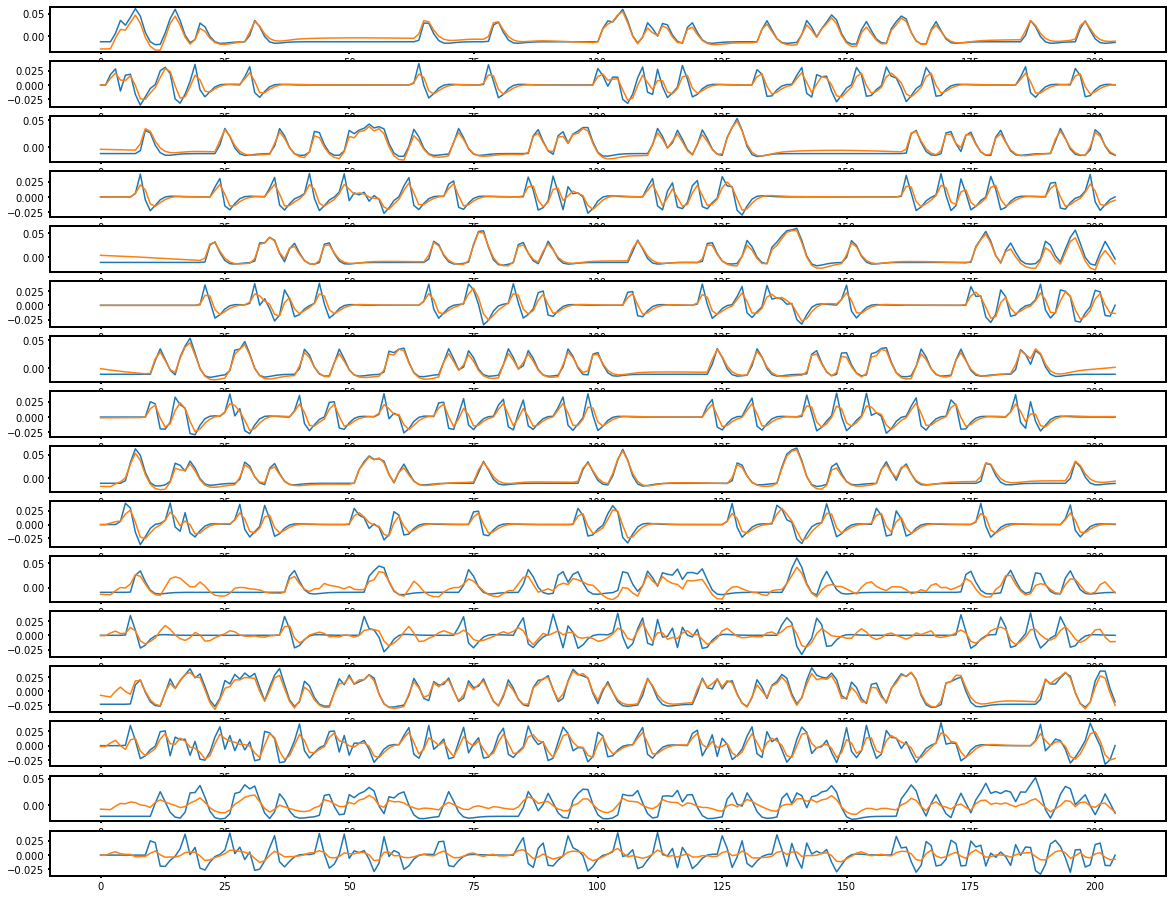

In [7]:
fig, ax = plt.subplots(figsize=(20, 2*8), nrows=16)
for i, reg in enumerate(regs):
    ax[i].plot(reg)
    ax[i].plot(mat[i])
    print(stats.pearsonr(reg, mat[i]))

In [8]:
# Load timeseries
img_path = os.path.join(root, "data/output/highpass/ses_%03dsub_%03d/_hp_filter%d" % (ses, sub, scn), "run_%03d_st_mcf_warp_dtype_bet_intnorm_smooth_hpf.nii.gz" % scn)
img = nib.load(img_path)
d = img.get_data()

# Mask data
mean = d.mean(axis=3)
mask = mean > 1000

# Run GLM
Y = d[mask]
b = glm(Y, regs)

Text(0.5, 1.0, 'FSL')

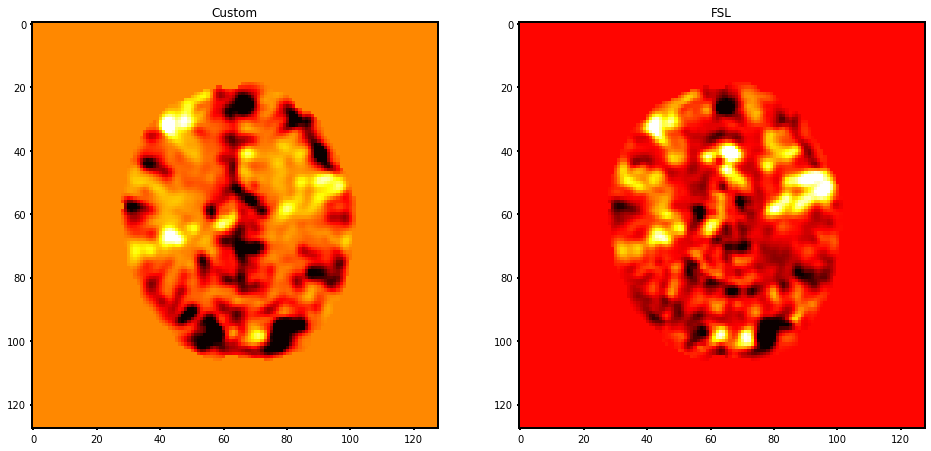

In [9]:
# Select PEs
pe = 0

# Load FSL pe
pe_path = os.path.join(root, "data/output/pop_decay_filmgls/sub_%03d/_pop_decay_filmgls%d" % (sub, run), "pe%d.nii.gz" % ((pe)+1))
pe_img = nib.load(pe_path)

blank = np.zeros(mean.shape)
blank[mask] = b[pe, :]

fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].imshow(
    np.rot90(blank[:,:, 17]), 
    vmin=blank.min()*.3, 
    vmax=blank.max()*.3, 
    cmap="hot")
ax[0].set_title("Custom")
ax[1].imshow(
    np.rot90(pe_img.get_data()[:, :, 17]),
    vmin=pe_img.get_data().min()*.3, 
    vmax=pe_img.get_data().max()*.3, 
    cmap="hot")
ax[1].set_title("FSL")

# ROI Analysis

## Create regressors

In [10]:
nback = 12
columns = ["tgt_loc%d" % i for i in range(4*2)] 
columns += ["loc%d" % (i+1) for i in range(nback*2)] 
columns += ["clr%d" % (i+1) for i in range(nback*2)]
all_regs = pd.DataFrame()
tu = .1
hrf = create_hrf(time_unit=tu, undershoot_delay=12, response_delay=5, resp_undershoot_ratio=6)

for (sub, ses, scn), group in stimuli.groupby(["sub", "real_ses", "scn"]):
    onsets = group.onset
    X = array2dummies(group.tgt_loc.values)
    X = add_regressors(X, n_back_series(group.tgt_loc.values, nback))
    X = add_regressors(X, n_back_series(group.tgt_clr.values, nback))
    
    regs = []
    for i, x in enumerate(X):
        t, reg = create_regressor(length, onsets, x, hrf=hrf, time_unit=tu)

        diff = np.append(np.diff(reg), 0)

        reg -= reg.mean()
        diff -= diff.mean()

        regs.append(reg)
        regs.append(diff)
        
    df = pd.DataFrame(np.array(regs).T, columns=columns)
    df = df.assign(**{
        "sub": sub,
        "ses": ses,
        "scn": scn,
        "t": t,
    })
    
    all_regs = all_regs.append(df)

all_regs = all_regs.set_index(["sub", "ses", "scn", "t"])

## Run glm in ROIs

In [ ]:
all_b_clr = pd.DataFrame()
all_b_loc = pd.DataFrame()

for sub, sess in sessions.items():

    clr_rois_path = os.path.join(root, "data", "output", "postprocessing", "rois", "sub_%03d" % sub, "clr")
    loc_rois_path = os.path.join(root, "data", "output", "postprocessing", "rois", "sub_%03d" % sub, "loc")

    clr_rois = os.listdir( clr_rois_path )
    loc_rois = os.listdir( loc_rois_path )
 
    for ses in sess:
        path = raw_files % (ses, sub)
        scns = os.listdir(path)
        for scn, scn_dir in enumerate(sorted(scns)):
            print(sub, ses, scn)
            file = os.path.join(path, scn_dir, "run_%03d_st_mcf_warp_dtype_bet_intnorm_smooth_hpf.nii.gz" % scn)
            img = nib.load(file)
            
            cols = all_regs.columns
            tgt_cols = all_regs.columns[all_regs.columns.str.contains("tgt")].tolist()
            clr_cols = all_regs.columns[all_regs.columns.str.contains("clr")].tolist()
            loc_cols = all_regs.columns[all_regs.columns.str.contains("loc") & ~all_regs.columns.str.contains("tgt")].tolist()
            
            Xclr = all_regs.loc[(sub, ses, scn), tgt_cols + clr_cols].values.T
            Xloc = all_regs.loc[(sub, ses, scn), tgt_cols + loc_cols].values.T

            # Do color
            dct = {}
            for clr_roi in clr_rois:
                roi_img = nib.load(os.path.join(clr_rois_path, clr_roi))
                mask = roi_img.get_data().astype(bool)
                roi_data = img.get_data()[mask]
                roi_mean = roi_data.mean(axis=0)
                
                b = glm(roi_mean, Xclr)
                dct[clr_roi.split(".")[0]] = b
                
            df_clr = pd.DataFrame(dct)
            df_clr = df_clr.assign(**{
                "sub": sub,
                "ses": ses,
                "scn": scn,        
            })
            
            df_clr = df_clr.assign(reg=tgt_cols + clr_cols)
            
            # Do location
            dct = {}
            for loc_roi in loc_rois:
                roi_img = nib.load(os.path.join(loc_rois_path, loc_roi))
                mask = roi_img.get_data().astype(bool)
                roi_data = img.get_data()[mask]
                roi_mean = roi_data.mean(axis=0)
                
                b = glm(roi_mean, Xloc)
                dct[loc_roi.split(".")[0]] = b
                
            df_loc = pd.DataFrame(dct)
            df_loc = df_loc.assign(**{
                "sub": sub,
                "ses": ses,
                "scn": scn,        
            })            
            
            df_loc = df_loc.assign(reg=tgt_cols + loc_cols)
           
            all_b_clr = all_b_clr.append(df_clr)
            all_b_loc = all_b_loc.append(df_loc)
            
all_b_loc.to_csv("../data/roi_b_loc2.csv")
all_b_clr.to_csv("../data/roi_b_clr2.csv")

In [12]:
all_b_loc = pd.read_csv("../data/roi_b_loc2.csv")
# all_b_loc.groupby(["sub", "reg"]).mean()

In [13]:
all_b_clr = pd.read_csv("../data/roi_b_clr2.csv")
# all_b_clr.groupby(["sub", "reg"]).mean().groupby("reg").mean()

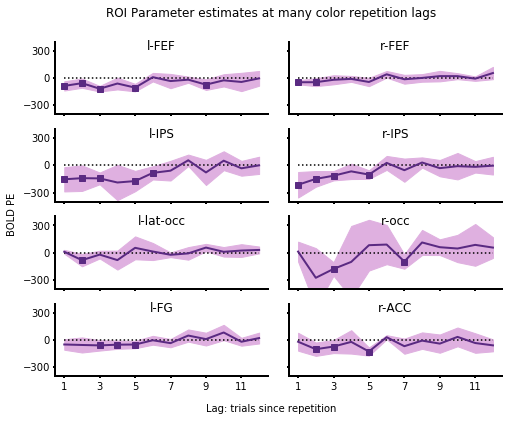

In [14]:
clr = all_b_clr.reset_index()
s = clr[clr.reg.str.contains("clr")]
s = s.assign(regn=s.reg.apply(lambda x: int(x[3:])))

clr_cols = {
    'l-fef_peak': "l-FEF",
    'r-fef_peak': "r-FEF",
    'l-ips_peak': "l-IPS",
    'r-ips_peak': "r-IPS",
    'l-lat-occ_peak': "l-lat-occ", 
    'r-occ_peak': "r-occ",
    'l-fg_peak': "l-FG", 
    'r-acc_peak': "r-ACC",
}
    

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, sharey=True, figsize=(8, 6))
for i, (clr_col, title) in enumerate(clr_cols.items()):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    y = s.groupby(["sub", "regn"])[clr_col].mean().groupby("regn").mean()
    yerr = s.groupby(["sub", "regn"])[clr_col].mean().groupby("regn").sem() * 2.015
    y = y.loc[y.index[::2]]
    yerr = yerr.loc[yerr.index[::2]]
    y.plot(ax=ax, linewidth=2, color="#5a2a82")
    
    m = (y+yerr) < 0
    if m.any():
        y[m].plot(ax=ax, marker="s", linewidth=0, color="#5a2a82")
        
    ax.fill_between(y.index, y1=y-yerr, y2=y+yerr, color="#dfb0e0")
    ax.hlines(0, *ax.get_xlim(), color="black", linestyle=":")
    ax.set_title(title, y=.8)
    ax.set_ylim(-400, 400)
    ax.set_yticks([-300, 0, 300])
    ax.set_xticks(y.index[::2])
    ax.set_xticklabels(range(1, 13)[::2])
    ax.set_xlim(0, 24)
    ax.set_xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.text(0.5, 0.05, "Lag: trials since repetition", ha='center', va='center')
fig.text(0.05, 0.5, "BOLD PE", ha='center', va='center', rotation='vertical')
fig.subplots_adjust(wspace=.1, top=.9)
fig.suptitle("ROI Parameter estimates at many color repetition lags")
fig.savefig("../images/color_BOLD_12lags.svg", dpi=300)

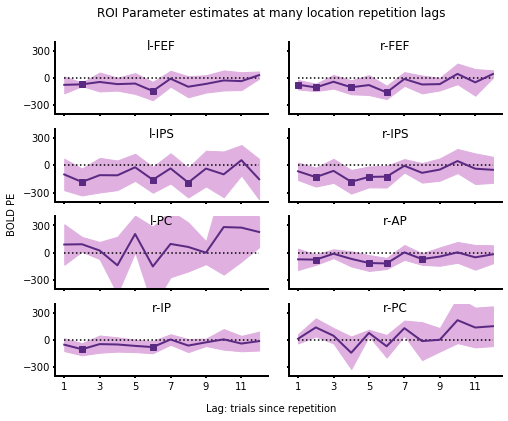

In [15]:
loc = all_b_loc.reset_index()
s = loc[loc.reg.str.contains("loc") & ~loc.reg.str.contains("tgt")]
s = s.assign(regn=s.reg.apply(lambda x: int(x[3:])))

loc_cols = {
    'lfef_peak' : "l-FEF",
    'rfef_peak' : "r-FEF",  
    'lips_peak' : "l-IPS",
    'rips_peak' : "r-IPS",  
    'lpc_peak' : "l-PC", 
    'rap_peak' : "r-AP",
    'rip_peak' : "r-IP", 
    'rpc_peak' : "r-PC",
}

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, sharey=True, figsize=(8, 6))
for i, (loc_col, title) in enumerate(loc_cols.items()):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    y = s.groupby(["sub", "regn"])[loc_col].mean().groupby("regn").mean()
    yerr = s.groupby(["sub", "regn"])[loc_col].mean().groupby("regn").sem() * 2.01
    y = y.loc[y.index[::2]]
    yerr = yerr.loc[yerr.index[::2]]
    y.plot(ax=ax, linewidth=2, color="#5a2a82")
    
    m = (y+yerr) < 0
    if m.any():
        y[m].plot(ax=ax, marker="s", linewidth=0, color="#5a2a82")
    
    ax.fill_between(y.index, y1=y-yerr, y2=y+yerr, alpha=1, color="#dfb0e0")
    ax.hlines(0, *ax.get_xlim(), color="black", linestyle=":")
    ax.set_title(title, y=.8)
    ax.set_ylim(-400, 400)
    ax.set_yticks([-300, 0, 300])
    ax.set_xticks(y.index[::2])
    ax.set_xticklabels(range(1,13)[::2])
    ax.set_xlim(0, 24) 
    ax.set_xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.text(0.5, 0.05, "Lag: trials since repetition", ha='center', va='center')
fig.text(0.05, 0.5, "BOLD PE", ha='center', va='center', rotation='vertical')    
fig.subplots_adjust(wspace=.1, top=.9)
fig.suptitle("ROI Parameter estimates at many location repetition lags")
fig.savefig("../images/location_BOLD_12lags.svg", dpi=300)

In [56]:
loc = all_b_loc.reset_index()
s = loc[loc.reg.str.contains("loc") & ~loc.reg.str.contains("tgt")]
s = s.assign(regn=s.reg.apply(lambda x: int(x[3:])))